In [34]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from keras.utils import to_categorical
from collections import Counter
from PIL import Image
import glob
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [40]:
import os
import shutil

def organize_images(base_dir):
    # Iegūst visas bildes sākotnējā direktorijā
    all_images = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
    
    # Izveido nepieciešamās mapes, ja tās vēl neeksistē
    for i in range(1, 6):  # Pirkstu skaita klases no 1 līdz 5
        new_dir = os.path.join(base_dir, str(i))
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
    
    # Pārvieto attēlus uz atbilstošām mapēm
    for image in all_images:
        # Iegūst pirkstu skaitu no faila nosaukuma (piemēram, '1_12.jpg')
        finger_count = image.split('_')[0]
        source = os.path.join(base_dir, image)
        destination = os.path.join(base_dir, finger_count, image)
        shutil.move(source, destination)
        print(f'Moved {source} to {destination}')

# Izsauc funkciju abām direktorijām
organize_images('rokas_train')
organize_images('rokas_validate')

Moved rokas_train\1_1.jpg to rokas_train\1\1_1.jpg
Moved rokas_train\1_10.jpg to rokas_train\1\1_10.jpg
Moved rokas_train\1_100.jpg to rokas_train\1\1_100.jpg
Moved rokas_train\1_101.jpg to rokas_train\1\1_101.jpg
Moved rokas_train\1_102.jpg to rokas_train\1\1_102.jpg
Moved rokas_train\1_103.jpg to rokas_train\1\1_103.jpg
Moved rokas_train\1_104.jpg to rokas_train\1\1_104.jpg
Moved rokas_train\1_105.jpg to rokas_train\1\1_105.jpg
Moved rokas_train\1_106.jpg to rokas_train\1\1_106.jpg
Moved rokas_train\1_107.jpg to rokas_train\1\1_107.jpg
Moved rokas_train\1_108.jpg to rokas_train\1\1_108.jpg
Moved rokas_train\1_109.jpg to rokas_train\1\1_109.jpg
Moved rokas_train\1_11.jpg to rokas_train\1\1_11.jpg
Moved rokas_train\1_110.jpg to rokas_train\1\1_110.jpg
Moved rokas_train\1_111.jpg to rokas_train\1\1_111.jpg
Moved rokas_train\1_112.jpg to rokas_train\1\1_112.jpg
Moved rokas_train\1_113.jpg to rokas_train\1\1_113.jpg
Moved rokas_train\1_114.jpg to rokas_train\1\1_114.jpg
Moved rokas_train\

In [35]:


class SingleFolderDataGenerator(Sequence):
    def __init__(self, filepaths, labels, batch_size=32, target_size=(256, 256), shuffle=True):
        self.filepaths = filepaths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.samples = len(filepaths)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, self.samples)
        indices = self.indexes[start:end]
        batch_paths = [self.filepaths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]
        if not batch_paths or not batch_labels:
            return np.zeros((0, *self.target_size, 3)), np.zeros((0,))  # Empty but correctly shaped arrays
        return self.__generate_data(batch_paths, batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(self.samples)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_data(self, batch_paths, batch_labels):
        images = []
        labels = []
        for path, label in zip(batch_paths, batch_labels):
            try:
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img)
                img /= 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
        if not images:
            return np.empty((0, *self.target_size, 3)), np.empty((0,))
        return np.array(images), np.array(labels)

def create_generators(folder_path, batch_size=32, target_size=(256, 256), test_size=0.2, random_seed=42):
    filenames = os.listdir(folder_path)
    filepaths = [os.path.join(folder_path, f) for f in filenames]
    labels = [int(f.split('_')[0]) - 1 for f in filenames]

    paths_train, paths_val, labels_train, labels_val = train_test_split(
        filepaths, labels, test_size=test_size, random_state=random_seed
    )

    train_gen = SingleFolderDataGenerator(paths_train, labels_train, batch_size, target_size)
    val_gen = SingleFolderDataGenerator(paths_val, labels_val, batch_size=10, target_size=target_size)

    return train_gen, val_gen
train_generator, validate_generator = create_generators('rokas_train', batch_size=32, target_size=(256, 256))

(32, 256, 256, 3) (32,)


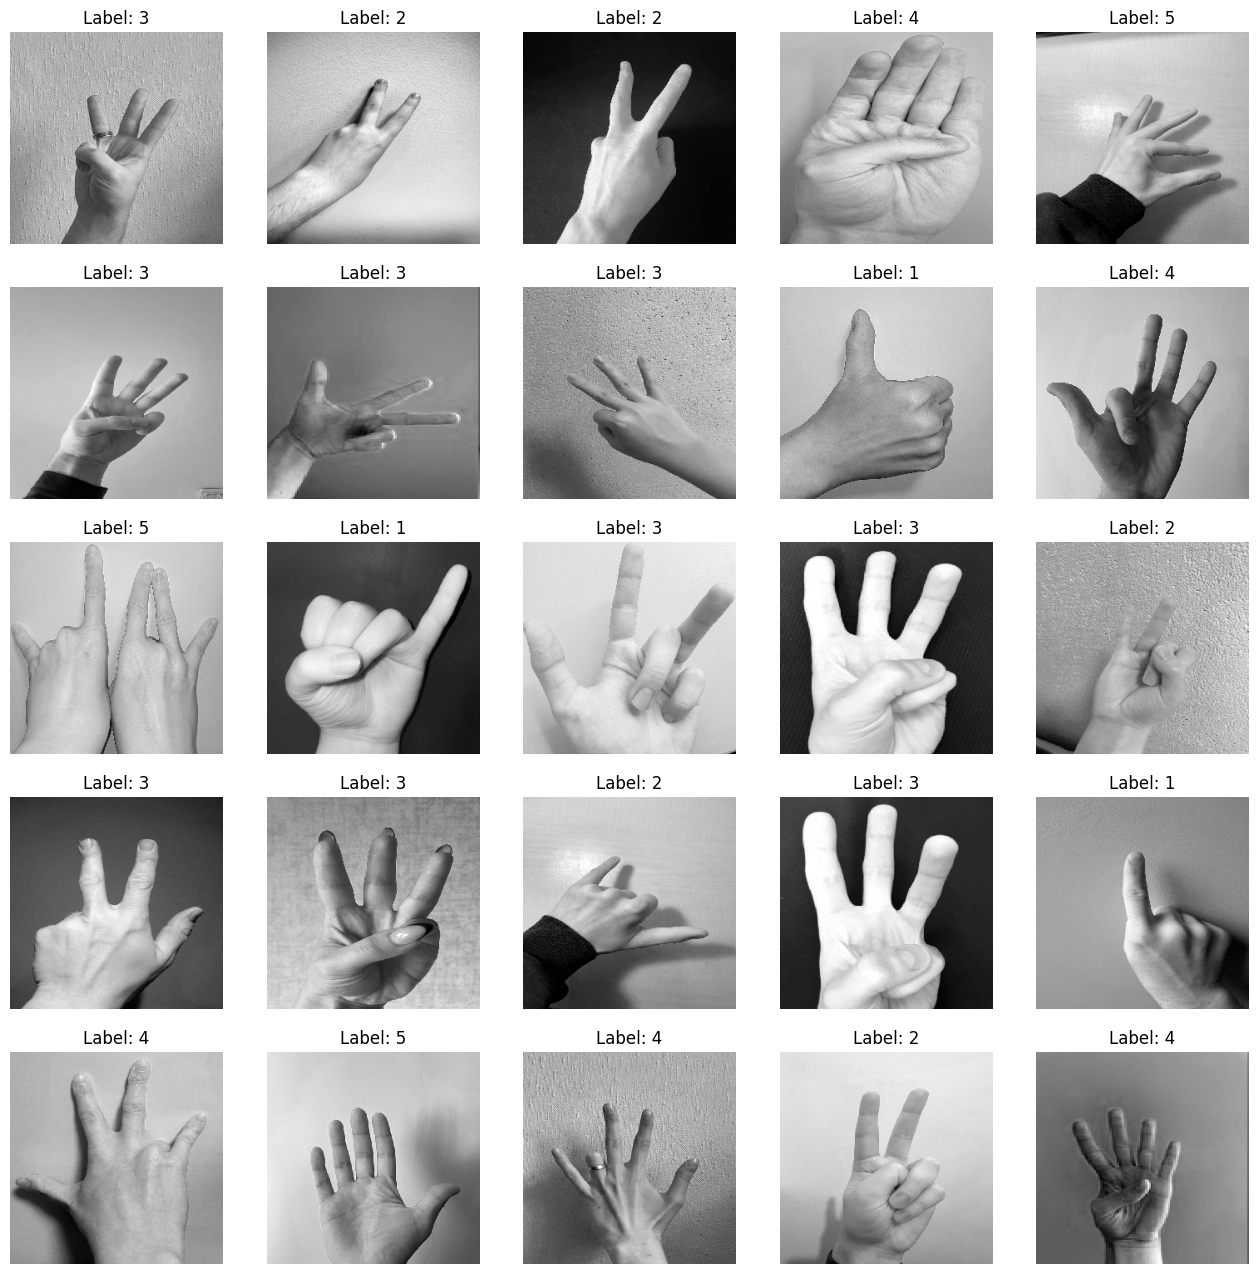

In [36]:
for X, y in train_generator:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):  # Ensure there are enough images in the batch to do this
        plt.subplot(5, 5, i + 1)
        plt.axis('off')
        plt.title(f'Label: {y[i] + 1}')  # Direct use of label
        img = np.uint8(255 * X[i, :, :, 0])  # Assuming grayscale for visualization, adjust if RGB
        plt.imshow(img, cmap='gray')
    plt.show()  # Show the plot
    break

In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # Ensure this matches the actual number of classes, which should be 5.
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,965 (49.93 MB)

 Trainable params: 13,088,965 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
train_images, train_labels = train_generator[0]
validate_images, validate_labels = validate_generator[0]

print("Training batch shapes:", train_images.shape, train_labels.shape)
print("Validation batch shapes:", validate_images.shape, validate_labels.shape)

def check_generator_output(generator):
    for idx in range(len(generator)):
        try:
            data, labels = generator[idx]
            if data is None or labels is None:
                print(f"Batch {idx} contains None values")
            elif data.shape[0] == 0:
                print(f"Batch {idx} has no samples")
        except Exception as e:
            print(f"Error processing batch {idx}: {e}")

# Check outputs of both generators
print("Checking training generator output:")
check_generator_output(train_generator)
print("Checking validation generator output:")
check_generator_output(validate_generator)

def check_generator_output(generator):
    for idx in range(len(generator)):
        data, labels = generator[idx]
        if not isinstance(data, np.ndarray) or not isinstance(labels, np.ndarray):
            print(f"Batch {idx} data type mismatch: data type {type(data)}, labels type {type(labels)}")
        if data.size == 0 or labels.size == 0:
            print(f"Batch {idx} contains empty arrays")

# Re-run the check with additional type and size validations
print("Checking training generator output:")
check_generator_output(train_generator)
print("Checking validation generator output:")
check_generator_output(validate_generator)

Training batch shapes: (32, 256, 256, 3) (32,)
Validation batch shapes: (10, 256, 256, 3) (10,)
Checking training generator output:
Checking validation generator output:
Checking training generator output:
Checking validation generator output:


In [39]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=100,
        validation_data=validate_generator,
        validation_steps=len(validate_generator),
    )
except Exception as e:
    print(f"An error occurred during model training: {e}")

Epoch 1/100
19/19 - 8s - 438ms/step - accuracy: 0.1844 - loss: 1.6972 - val_accuracy: 0.2027 - val_loss: 1.6090
Epoch 2/100
An error occurred during model training: 'NoneType' object has no attribute 'items'
